In [6]:
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score
from base.statistics import specificity_score
from base.statistics import roc_report
import glob
import matplotlib.pyplot as plt
from nilearn import plotting as niplt
sns.set_context('talk')
sns.set_style('ticks')
%load_ext autoreload
%autoreload 2
import nibabel as nib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load('../data/0.6/datasets/db_v6_topics-100.pkl')

###  Predict base

In [27]:
predictions = [pd.read_pickle(p) for p in glob.glob('../results/classification/cv_clust_predict/*base*.pkl')]
predictions = pd.concat(predictions)

In [28]:
predictions['atlas'] = predictions.atlas.map({'ns_base' : 'K-means (original)', 'ns_base_scaled' : 'K-means (stand.)', 'ns_base_scaled_ward' : 'Ward (original)', 'ns_base_ward' : 'Ward (stand.)'})

In [29]:
predictions['all_pos'] = (predictions.apply(lambda x: x.y_test.mean() == 1, axis=1))

predictions = predictions[predictions.all_pos != 1]

In [30]:
predictions['roc_auc_score'] = predictions.apply(lambda x: roc_auc_score(x['y_test'], x['y_pred']), axis=1)
predictions['sensitivity'] = predictions.apply(lambda x: recall_score(x['y_test'], x['y_pred']), axis=1)
predictions['specificity'] = predictions.apply(lambda x: specificity_score(x['y_test'], x['y_pred']), axis=1)

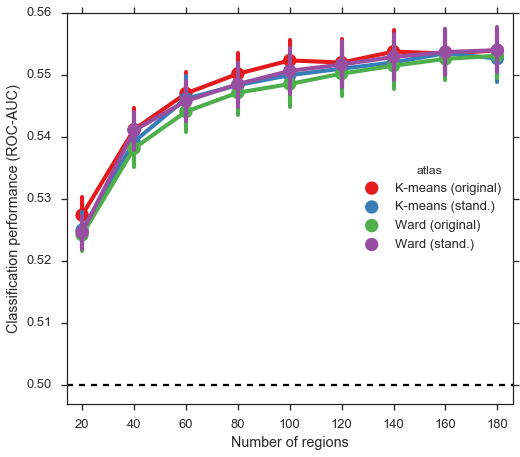

In [34]:
plt.figure(figsize=(8, 7))

p = sns.pointplot('n_regions', 'roc_auc_score', hue='atlas', 
           data=predictions, fit_reg=True, 
           size=8, scatter_kws={"s": 40}, logx=True, ci=95, scatter=False, palette = sns.color_palette('Set1', 4))
p.axes.set_xlim(-.3, 8.3)
p.axes.set_ylim(0.497, 0.56)

plt.plot(np.arange(-10, 300, 0.1), np.repeat(0.5, 3100), linestyle='--', color='black')
p.axes.set_xlabel('Number of regions')
p.axes.set_ylabel('Classification performance (ROC-AUC)')

In [386]:
tmean_pred_base = predictions.groupby(['atlas', 'n_regions']).mean().reset_index()

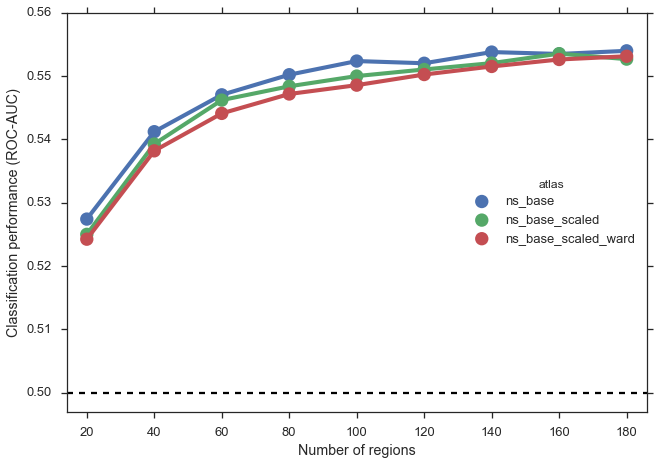

In [456]:
p = sns.pointplot('n_regions', 'roc_auc_score', hue='atlas', 
           data=tmean_pred_base, fit_reg=True, 
           size=8, scatter_kws={"s": 85}, logx=True, ci=False)
p.axes.set_xlabel('Number of regions')
p.axes.set_ylabel('Classification performance (ROC-AUC)')
p.axes.set_xlim(-.3, 8.3)
p.axes.set_ylim(0.497, 0.56)

plt.plot(np.arange(-10, 300, 0.1), np.repeat(0.5, 3100), linestyle='--', color='black')

In [416]:
?p.axes.set_xlim

In [ ]:
p.axes.set_x

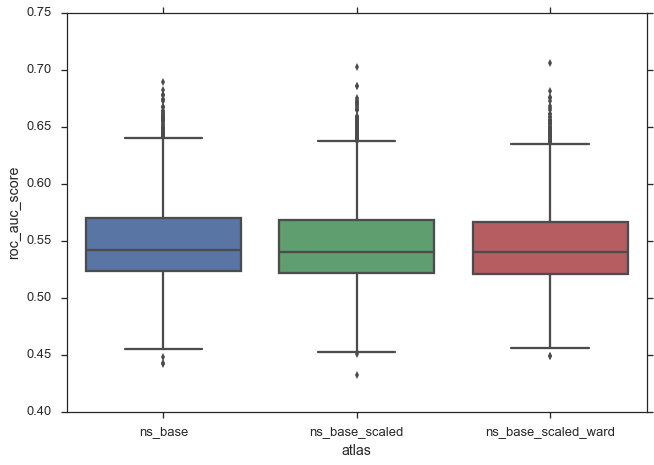

In [400]:
sns.boxplot('atlas', 'roc_auc_score', data=predictions)

In [391]:
?ttest_rel

In [395]:
ttest_rel(predictions[predictions.atlas == 'ns_base'].roc_auc_score, predictions[predictions.atlas == 'ns_base_scaled'].roc_auc_score)

(6.6224464753379886, 4.0722952061835151e-11)

In [401]:
ttest_rel(predictions[predictions.atlas == 'ns_base_ward'].roc_auc_score, predictions[predictions.atlas == 'ns_base_scaled_ward'].roc_auc_score)

ValueError: unequal length arrays

### Predict activation

In [17]:
good_topics = ['17_reading_letter_visual',
 '18_error_errors_reaction',
 '19_goal_directed_monitoring',
 '21_stimulation_somatosensory_tactile',
 '22_speech_auditory_sounds',
 '23_reward_anticipation_monetary',
 '24_food_weight_eating',
 '26_inhibition_stop_inhibitory',
 '27_training_practice_learning',
 '28_number_numbers_numerical',
 '29_verbs_verb_nouns',
 '2_pain_ocd_painful',
 '30_eye_eyes_saccades',
 '31_phonological_orthographic_words',
 '32_congruent_incongruent_hd',
 '33_language_chinese_native',
 '34_causal_selection_causality',
 '36_effort_cultural_status',
 '37_rate_heart_autonomic',
 '38_number_core_unique',
 '39_taste_olfactory_odor',
 '3_social_empathy_person',
 '40_memory_working_wm',
 '42_memory_encoding_retrieval',
 '43_personality_trait_traits',
 '44_emotional_emotion_regulation',
 '46_reasoning_mental_mentalizing',
 '48_decision_choice_decisions',
 '49_visual_auditory_sensory',
 '4_words_word_semantic',
 '50_gaze_direction_intention',
 '51_category_categories_categorization',
 '52_strategies_strategy_run',
 '53_cues_cue_target',
 '56_meditation_shifting_mindfulness',
 '58_face_faces_recognition',
 '59_language_production_naming',
 '60_visual_blind_sighted',
 '61_motor_movements_movement',
 '62_perceptual_demands_selection',
 '63_repetition_adaptation_priming',
 '64_stress_cortisol_infant',
 '66_gestures_abstract_verbal',
 '67_shape_shapes_visual',
 '68_mental_rotation_orientation',
 '69_judgments_judgment_referential',
 '6_emotional_faces_facial',
 '71_attention_attentional_visual',
 '72_rule_sequences_rules',
 '73_pictures_experience_scenes',
 '74_arithmetic_calculation_mental',
 '75_risk_taking_history',
 '77_pd_motor_parkinson',
 '78_deception_loss_unfair',
 '79_conditioning_cs_conditioned',
 '7_action_actions_motor',
 '80_music_musical_pitch',
 '81_memory_imagery_autobiographical',
 '82_conflict_interference_stroop',
 '84_anxiety_threat_anxious',
 '85_target_targets_search',
 '86_items_recognition_memory',
 '87_awareness_conscious_consciousness',
 '89_asd_switching_default',
 '8_perspective_virtual_person',
 '90_motor_stroke_force',
 '91_sleep_swallowing_deprivation',
 '93_semantic_body_knowledge',
 '94_motion_perception_visual',
 '95_asymmetry_language_dominance',
 '96_fear_extinction_skin',
 '98_learning_feedback_implicit',
 '99_sentences_comprehension_language',
 '9_expertise_experts_novices']

In [59]:
predictions = [pd.read_pickle(p) for p in glob.glob('../results/classification/cv_clust_predict/comparison/topics*.pkl')]

In [60]:
predictions = pd.concat(predictions)

In [61]:
predictions['all_pos'] = (predictions.apply(lambda x: x.y_test.mean() == 1, axis=1))

predictions = predictions[predictions.all_pos != 1]
predictions = predictions[predictions.region.isin(good_topics)]

In [62]:
predictions['roc_auc_score'] = predictions.apply(lambda x: roc_auc_score(x['y_test'], x['y_pred']), axis=1)
# predictions['sensitivity'] = predictions.apply(lambda x: recall_score(x['y_test'], x['y_pred']), axis=1)
# predictions['specificity'] = predictions.apply(lambda x: specificity_score(x['y_test'], x['y_pred']), axis=1)

In [63]:
predictions.groupby('atlas').mean()

,fold,n_regions,all_pos,roc_auc_score
atlas,,,,
aal,1.5,116.000,False,0.541392
craddock,1.5,131.000,False,0.544835
gordon,1.5,334.000,False,0.543488
h_o,1.5,48.000,False,0.539651
ns_aal,1.5,116.000,False,0.553753
ns_craddock,1.5,131.000,False,0.550587
ns_craddock_ward,1.5,131.875,False,0.551173
ns_gordon,1.5,334.000,False,0.553466
ns_h_o,1.5,48.000,False,0.543656


In [64]:
predictions['atlas2'] = predictions.atlas.map({'ns_yeo17' : 'ns', 'yeo17' : 'yeo', 'ns_aal': 'ns', 'ns_craddock' : 'ns', 'ns_gordon' : 'ns', 'ns_h-o_thr25_bi':'ns', 'ns_h-o_thr25_uni' : 'ns',
                      'h-o_thr25_uni' : 'h-o_thr25_uni', 'h-o_thr25_bi' : 'h-o_thr25_bi',
                      'gordon' : 'gordon', 'craddock' : 'craddock', 'aal' : 'aal'})

In [41]:
mean_pred = predictions.groupby(['atlas2', 'n_regions']).mean().reset_index()

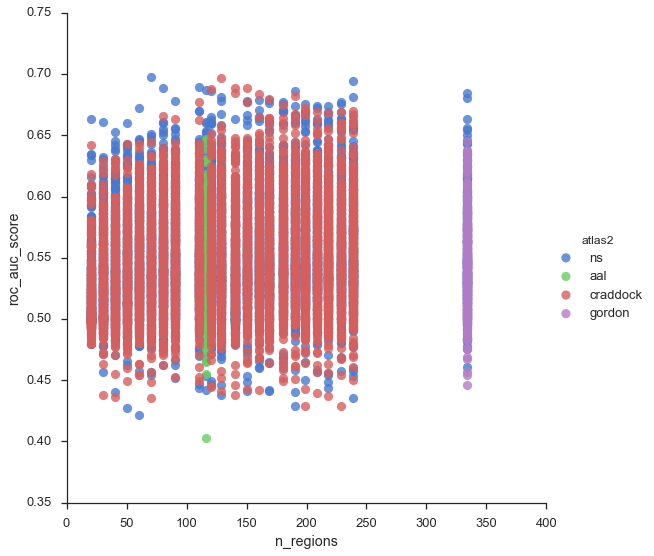

In [616]:
sns.lmplot('n_regions', 'roc_auc_score', hue='atlas2', data=predictions, fit_reg=False, 
           size=8, scatter_kws={"s": 85}, palette=sns.color_palette('muted', 6), lowess=True)

In [65]:
predictions['atlas_name'] = predictions.atlas.map({'ns_aal' : 'Neurosynth (k-means)', 'aal' : 'AAL', 
                                                   'ns_craddock' : 'Neurosynth (k-means)', 'craddock' : 'Craddock',
                                                  'ns_gordon' : 'Neurosynth (k-means)', 'gordon' : 'Gordon',
                                                  'ns_h_o' : 'Neurosynth (k-means)', 'h_o' : 'Harvard-Oxford',
                                                  'ns_craddock_ward' : 'Neurosynth (ward)', 
                                                  'ns_yeo17' : 'Neurosynth (k-means)',
                                                  'yeo17' : 'Yeo - 17'})

In [102]:
plot_data = predictions[predictions.atlas.isin(['ns_craddock', 'craddock'])]

In [103]:
plot_data = plot_data[(plot_data.n_regions == 140) == False]

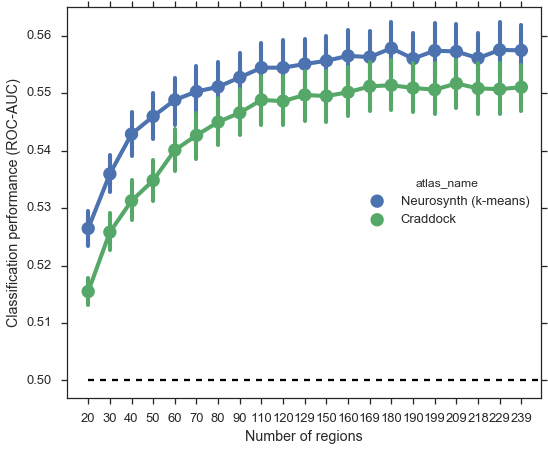

In [105]:
plt.figure(figsize=(8.5, 7))
p = sns.pointplot('n_regions', 'roc_auc_score', hue='atlas_name', 
           data=plot_data,  
           size=8, scatter_kws={"s": 45}, logx=True, ci=95)
p.axes.set_xlabel('Number of regions')
p.axes.set_ylabel('Classification performance (ROC-AUC)')
p.axes.set_xlim(-1, 20.9)
p.axes.set_ylim(0.497, 0.565)
plt.plot(np.arange(0, 300, 0.1), np.repeat(0.5, 3000), linestyle='--', color='black')

In [734]:
predictions.groupby('atlas').mean()

,fold,n_regions,all_pos,roc_auc_score,sensitivity,specificity
atlas,,,,,,
aal,1.494872,116.000000,False,0.540207,0.571222,0.878158
craddock,1.494872,131.000000,False,0.543435,0.496031,0.877784
gordon,1.494872,334.000000,False,0.541322,0.592295,0.877813
h_o,1.494872,48.000000,False,0.538688,0.439139,0.876621
ns_aal,1.494872,116.000000,False,0.552117,0.549703,0.880459
ns_craddock,1.494872,131.000000,False,0.549019,0.498739,0.879338
ns_craddock_ward,1.494872,131.875175,False,0.549606,0.510453,0.879870
ns_gordon,1.494872,334.000000,False,0.551193,0.569769,0.879642
ns_h_o,1.494872,48.000000,False,0.542861,0.427897,0.877633


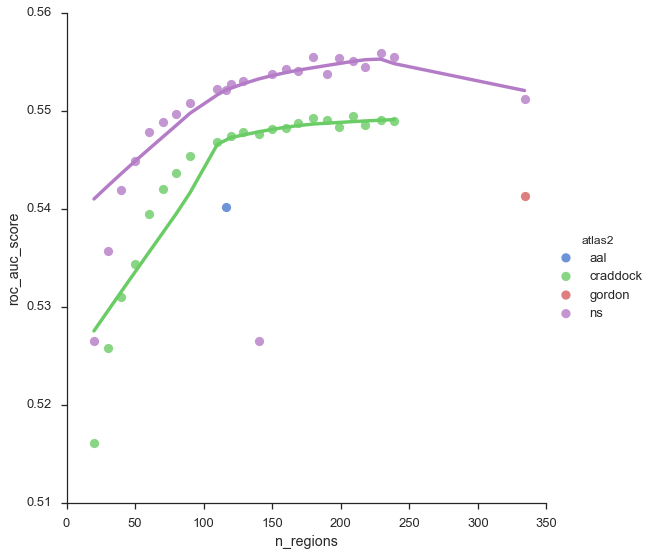

In [618]:
sns.lmplot('n_regions', 'roc_auc_score', hue='atlas2', data=mean_pred, fit_reg=True, 
           size=8, scatter_kws={"s": 85}, palette=sns.color_palette('muted', 6), lowess=True)

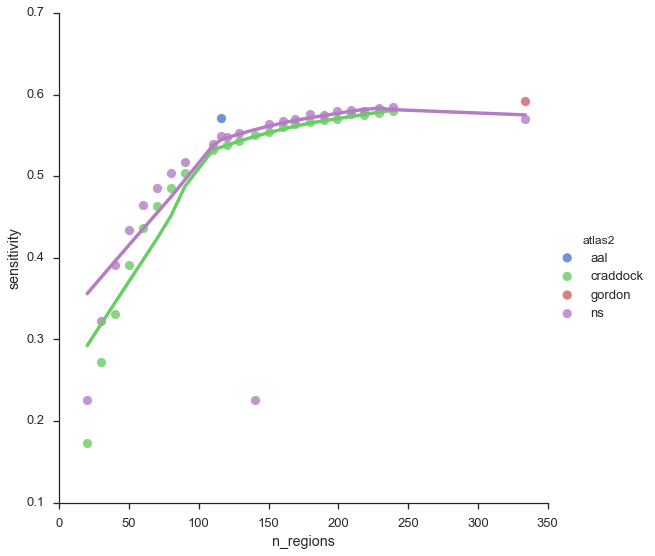

In [619]:
sns.lmplot('n_regions', 'sensitivity', hue='atlas2', data=mean_pred, fit_reg=True, 
           size=8, scatter_kws={"s": 85}, palette=sns.color_palette('muted', 6), lowess=True)

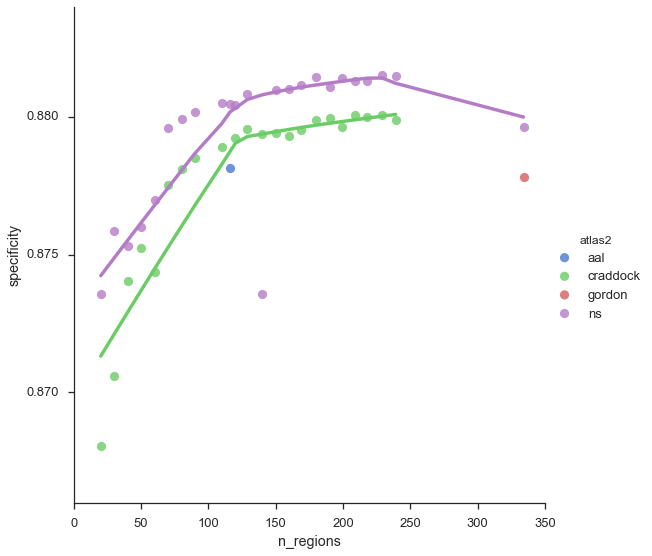

In [620]:
sns.lmplot('n_regions', 'specificity', hue='atlas2', data=mean_pred, fit_reg=True, 
           size=8, scatter_kws={"s": 85}, palette=sns.color_palette('muted', 6), lowess=True)

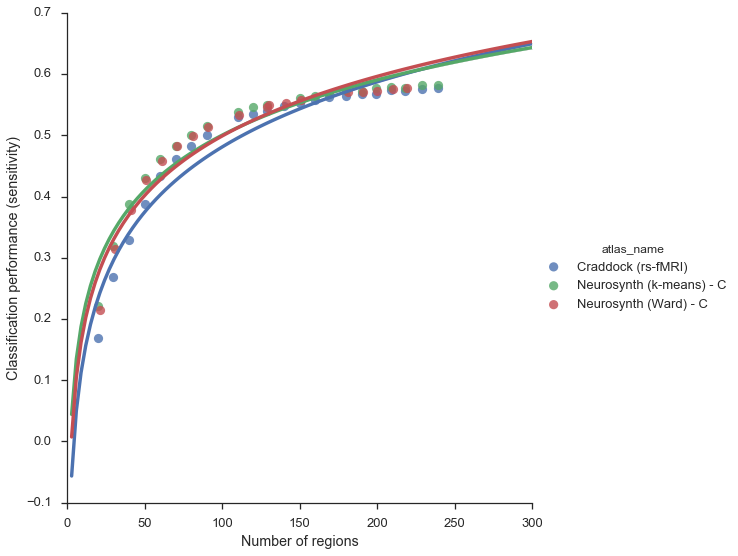

In [503]:
p = sns.lmplot('n_regions', 'sensitivity', hue='atlas_name', 
           data=tmean_pred[tmean_pred.atlas.isin(['ns_craddock', 'ns_craddock_ward', 'craddock'])], fit_reg=True, 
           size=8, scatter_kws={"s": 85}, logx=True, ci=False)
p.set_axis_labels(x_var='Number of regions', y_var='Classification performance (sensitivity)')

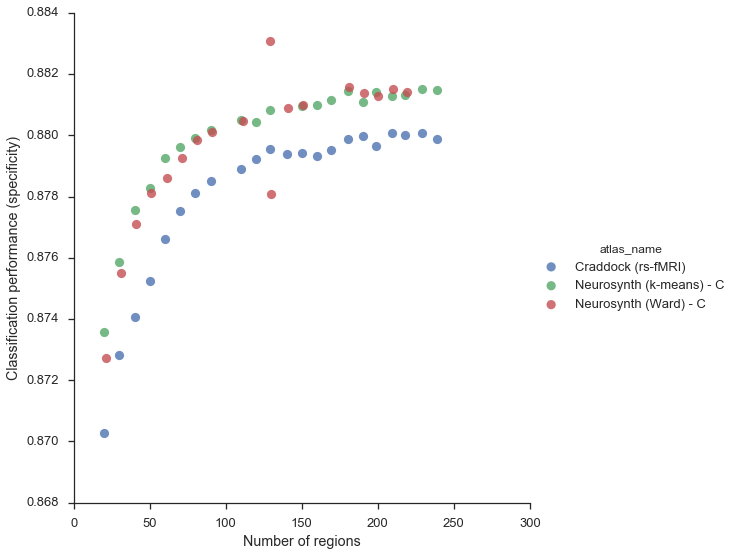

In [515]:
p = sns.lmplot('n_regions', 'specificity', hue='atlas_name', 
           data=tmean_pred[tmean_pred.atlas.isin(['ns_craddock', 'ns_craddock_ward', 'craddock'])], fit_reg=False, 
           size=8, scatter_kws={"s": 85}, ci=False)
p.set_axis_labels(x_var='Number of regions', y_var='Classification performance (specificity)')

In [505]:
atlas_data = tmean_pred[tmean_pred.atlas.isin(['ns_gordon', 'gordon', 'h_o', 'ns_h_o', 'aal','ns_aal'])]

In [506]:
atlas_data['roc_auc_score'] = np.round(atlas_data.roc_auc_score, 3)

-c:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [107]:
plot_data = predictions[predictions.atlas.isin(['ns_aal','ns_gordon', 'gordon', 'h_o', 'ns_h_o', 'aal', 'ns_yeo17', 'yeo17'])]

plt.figure(figsize=(5, 7))

p = sns.pointplot('n_regions', 'roc_auc_score', hue='atlas_name', 
           data=plot_data, fit_reg=False, 
           size=8, scatter_kws={"s": 180}, logx=True, ci=95, join=False, legend=False)
p.axes.set_xlabel('Number of regions')
p.axes.set_ylabel('Classification performance (ROC-AUC)')
plt.xlim(-.4, 3.6)
plt.ylim(0.495, 0.565)
plt.plot(np.arange(-10, 300, 0.1), np.repeat(0.5, 3100), linestyle='--', color='black')
plt.legend(loc=(.35, .15))

### Reliability

In [20]:
reliability = pd.concat([pd.read_csv(f) for f in glob.glob('../results/clustering/bootstrap/*.csv')])

In [21]:
reliability['label'] = reliability.algorithm + reliability.type

reliability['label'] = reliability.label.map({'kmeansraw' : 'K-means (original)', 'kmeansscaled' : 'K-means (stand.)', 
                                             'wardraw' : 'Ward (original)', 'wardscaled' : 'Ward (stand.)'})

In [35]:
colors = sns.color_palette('Set1', 4)

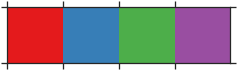

In [38]:
sns.palplot(colors)

In [40]:
colors = [colors[1], colors[0], colors[3], colors[2]]

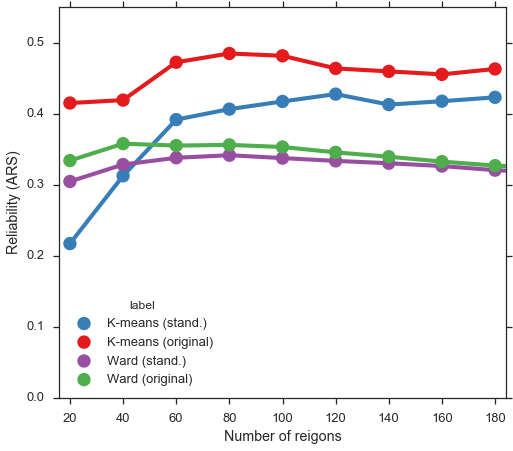

In [51]:
plt.figure(figsize=(8, 7))
g=sns.pointplot('n', 'ars', hue='label', data=reliability, fit_reg=False, size=8, scatter_kws={"s": 85}, palette=colors,
               legend_out=False)
g.set(xlim=(-.2, 8.2), ylim= (0, .55))
g.axes.set_xlabel('Number of reigons')
g.axes.set_ylabel('Reliability (ARS)')

### BrainMap ICA comparison

In [8]:
import nilearn.datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold
smith = nilearn.datasets.fetch_atlas_smith_2009()
from joblib import Parallel, delayed
from neurosynth.analysis.reduce import average_within_regions


In [9]:
def fit_predict(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    return [y_test, classifier.predict(X_test).tolist()]

In [10]:
classifier = GaussianNB()
cver = KFold(dataset.feature_table.data.shape[0], n_folds = 4)

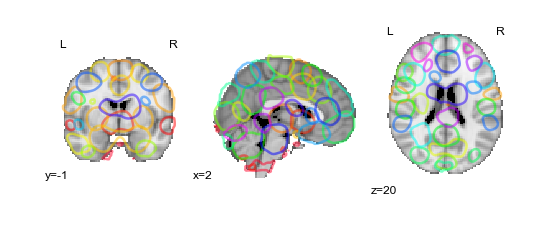

In [11]:
niplt.plot_prob_atlas(smith['bm70'], threshold=9, draw_cross=False)

/Users/aleph4/anaconda/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning: The given float value must not exceed 8. But, you have given threshold=9 
  threshold))


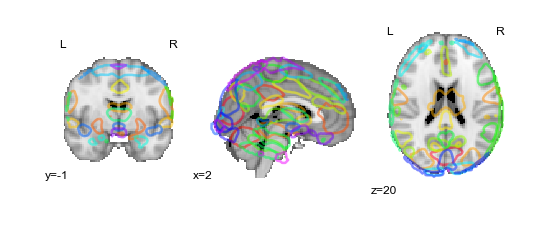

In [12]:
niplt.plot_prob_atlas(smith['rsn70'], threshold=9, draw_cross=False)

In [13]:
smith_predictions = []
for fold_i, (train_index, test_index) in enumerate(cver):
    ys = (dataset.feature_table.data.values > 0.001).astype('int').T
    for name in ['bm20', 'rsn20', 'bm70', 'rsn70']:
        data = nib.load(smith[name]).get_data()
        n_regions = data.shape[3]
        
        ## Extract average for each ICA component at given threshold
        X = np.vstack(
            [average_within_regions(
                    dataset, nib.Nifti1Image(
                        (data[:, :, :, i] > 9).astype('int'), None)) for i in range(n_regions)]).T

        match_predictions = Parallel(n_jobs=-1)(delayed(fit_predict)(
            classifier, X[train_index, :], X[test_index, :], y[train_index], y[test_index]) for y in ys)
        match_predictions = pd.DataFrame(match_predictions, columns=['y_test', 'y_pred'])
        match_predictions['region'] = dataset.get_feature_names()
        match_predictions['atlas'] = name
        match_predictions['fold'] = fold_i
        match_predictions['n_regions'] = n_regions
        smith_predictions.append(match_predictions)

In [14]:
smith_predictions = pd.concat(smith_predictions)

In [15]:
smith_predictions['atlas2'] = smith_predictions.atlas.map(
    {'bm20' : 'BrainMap', 'rsn20' : 'Resting-state', 'bm70' : 'BrainMap', 'rsn70' : 'Resting-state'})

In [18]:
smith_predictions['all_pos'] = (smith_predictions.apply(lambda x: x.y_test.mean() == 1, axis=1))

smith_predictions = smith_predictions[smith_predictions.all_pos != 1]
smith_predictions = smith_predictions[smith_predictions.region.isin(good_topics)]
smith_predictions['roc_auc_score'] = smith_predictions.apply(lambda x: roc_auc_score(x['y_test'], x['y_pred']), axis=1)

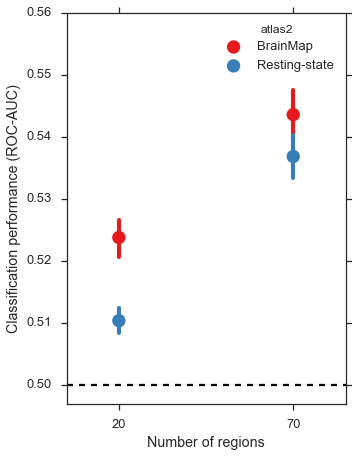

In [21]:
plt.figure(figsize=(5, 7))

p = sns.pointplot('n_regions', 'roc_auc_score', hue='atlas2', 
           data=smith_predictions, fit_reg=True, 
           size=8, scatter_kws={"s": 40}, logx=True, ci=95, scatter=False, join=False, palette = sns.color_palette('Set1', 4))
p.axes.set_xlim(-.3, 1.3)
p.axes.set_ylim(0.497, 0.56)

plt.plot(np.arange(-10, 300, 0.1), np.repeat(0.5, 3100), linestyle='--', color='black')
p.axes.set_xlabel('Number of regions')
p.axes.set_ylabel('Classification performance (ROC-AUC)')

### Scaled vs raw - activation by size of clusters

In [72]:
from scipy.cluster.hierarchy import fcluster, dendrogram, cophenet
from neurosynth.analysis.cluster import Clusterable
from neurosynth.base.dataset import Dataset
from base import tools
import glob

In [29]:
roi = Clusterable(dataset, min_studies=100)
masker = roi.masker

In [85]:
kmeans_labels = joblib.load('../results/clustering/bootstrap/kmeans/labels_wholebrain_raw_full.pkl') +  joblib.load(
    '../results/clustering/bootstrap/kmeans/labels_wholebrain_raw_full_100_180.pkl')
    
kmeans_scaled_labels = joblib.load('../results/clustering/bootstrap/kmeans/labels_wholebrain_scaled_full.pkl') + joblib.load(
    '../results/clustering/bootstrap/kmeans/labels_wholebrain_scaled_full_100_180.pkl')

In [88]:
regions, _ = zip(*kmeans_labels)

In [89]:
all_results = []
for n_reg, labels in kmeans_labels:
    img = nib.Nifti1Image(masker.unmask(labels + 1), masker.get_header().get_best_affine())
    base_rates = tools.region_vox_baserates(dataset, img)
    base_rates = base_rates.groupby('region').mean().reset_index()
    base_rates = pd.merge(base_rates, tools.region_n_vox(dataset, img))
    base_rates['Regions (N)'] = n_reg
    base_rates['algorithm'] = 'kmeans'
    base_rates['type'] = 'raw'
    all_results.append(base_rates)

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [677]:
from sklearn.metrics import silhouette_score

In [678]:
?silhouette_score

In [92]:
for n_reg, labels in kmeans_scaled_labels:
    img = nib.Nifti1Image(masker.unmask(labels + 1), masker.get_header().get_best_affine())
    base_rates = tools.region_vox_baserates(dataset, img)
    base_rates = base_rates.groupby('region').mean().reset_index()
    base_rates = pd.merge(base_rates, tools.region_n_vox(dataset, img))
    base_rates['Regions (N)' = n_reg
    base_rates['algorithm'] = 'kmeans'
    base_rates['type'] = 'scaled'
    all_results.append(base_rates)

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


#### Ward

In [187]:
Z_raw = joblib.load('../results/clustering/hierarchical/Z_ward_wholebrain_full.pkl')
ward_labels = [fcluster(Z_raw, region, 'maxclust') for region in regions]

Z_scaled = joblib.load('../results/clustering/hierarchical/Z_ward_wholebrain_scaled_full.pkl')
ward_scaled_labels = [fcluster(Z_scaled, region, 'maxclust') for region in regions]

In [221]:
len(fcluster(Z_raw, region, 'maxclust'))

151527

In [219]:
Z_raw.shape

(151526, 4)

In [220]:
masker.n_vox_in_mask

151527

In [176]:
for i, labels in enumerate(ward_labels):
    img = nib.Nifti1Image(masker.unmask(labels + 1), masker.get_header().get_best_affine())
    base_rates = tools.region_vox_baserates(dataset, img)
    base_rates = base_rates.groupby('region').mean().reset_index()
    base_rates = pd.merge(base_rates, tools.region_n_vox(dataset, img))
    base_rates['Regions (N)'] = regions[i]
    base_rates['algorithm'] = 'ward'
    base_rates['type'] = 'raw'
    all_results.append(base_rates)

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [188]:
for i, labels in enumerate(ward_scaled_labels):
    img = nib.Nifti1Image(masker.unmask(labels + 1), masker.get_header().get_best_affine())
    base_rates = tools.region_vox_baserates(dataset, img)
    base_rates = base_rates.groupby('region').mean().reset_index()
    base_rates = pd.merge(base_rates, tools.region_n_vox(dataset, img))
    base_rates['Regions (N)'] = regions[i]
    base_rates['algorithm'] = 'ward'
    base_rates['type'] = 'scaled'
    all_results.append(base_rates)

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [196]:
all_results = pd.concat(all_results)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [294]:
all_results.base_rate = all_results.base_rate * 100

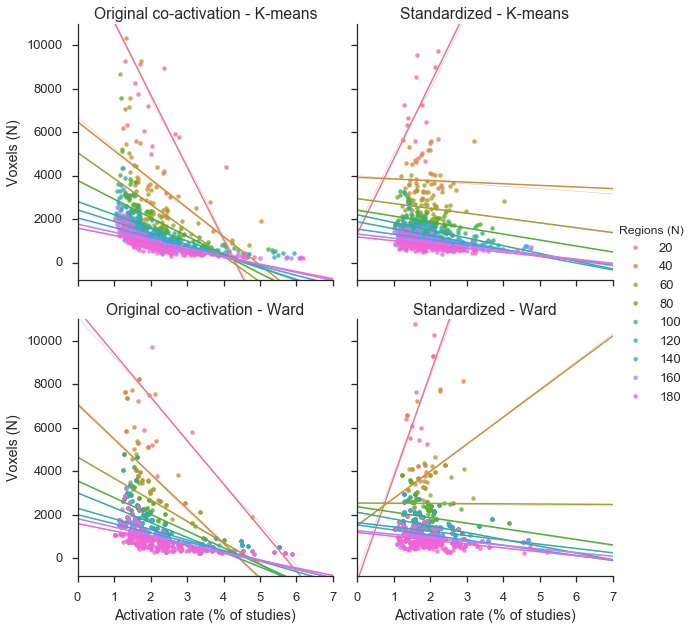

In [352]:
p = sns.lmplot('base_rate', 'n_vox', all_results, hue='Regions (N)', col='type', row='algorithm', ci=False, line_kws={
        'linewidth':1.5}, size=4.5)
p.set(ylim=(-800, 11000))
p.set_xlabels('Activation rate (% of studies)')
p.set_ylabels('Voxels (N)')

for ax, title in zip(p.axes.flat, ['Original co-activation - K-means', 'Standardized - K-means', 'Original co-activation - Ward', 'Standardized - Ward']):
    ax.set_title(title)

In [320]:
fm = sm.OLS(all_results.n_vox, all_results.base_rate).fit()

In [334]:
fm.pvalues.round(2)

base_rate    0
dtype: float64

In [340]:
from IPython.display import HTML

In [344]:
def ols_res(x, y):
    fm = sm.OLS(y, x).fit()
    return fm.params[0]

HTML(all_results.groupby(['algorithm', 'type', 'Regions (N)']).apply(lambda x : x[['base_rate']].apply(ols_res, y=x['n_vox'])).to_html())

In [203]:
mean_corr = all_results.groupby(['type', 'Regions (N)', 'algorithm']).corr().reset_index().drop(['region', 'base_rate'], axis=1)

In [206]:
mean_corr = mean_corr[mean_corr.level_3 == 'base_rate']

In [210]:
mean_corr[mean_corr['Regions (N)'] > 60].groupby(['algorithm', 'type']).mean()

Regions (N)     n_vox
algorithm type                         
kmeans    raw             130 -0.721339
          scaled          130 -0.479640
ward      raw             130 -0.643694
          scaled          130 -0.311648

In [260]:
import matplotlib.colors as mplcolors
from random import shuffle

In [269]:
colors = sns.hls_palette(100, l=.5, s=.85)
shuffle(colors)

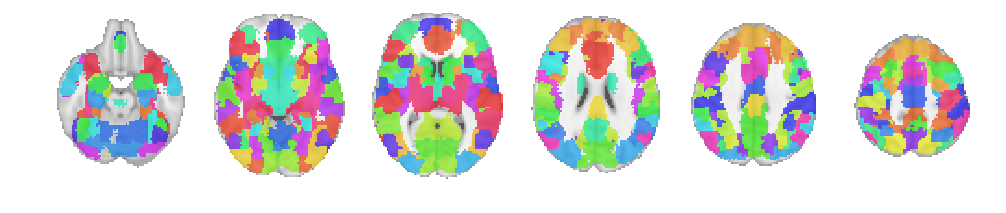

In [289]:
niplt.plot_roi(nib.Nifti1Image(masker.unmask(ward_labels[4] + 1), masker.get_header().get_best_affine()), draw_cross=False,
              cmap=mplcolors.ListedColormap(colors), display_mode='z', cut_coords=np.arange(-22, 55, 15), annotate=False)

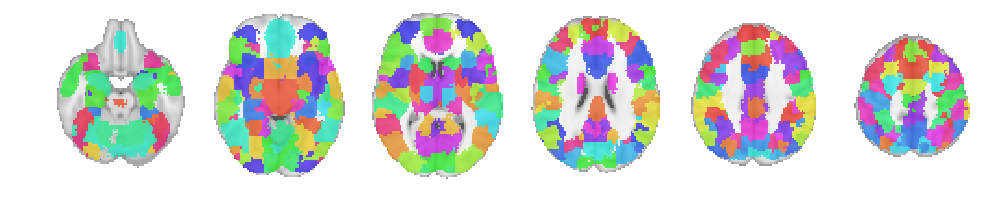

In [288]:
niplt.plot_roi(nib.Nifti1Image(masker.unmask(ward_scaled_labels[4] + 1), masker.get_header().get_best_affine()), draw_cross=False,
              cmap=mplcolors.ListedColormap(colors), display_mode='z', cut_coords=np.arange(-22, 55, 15), annotate=False)

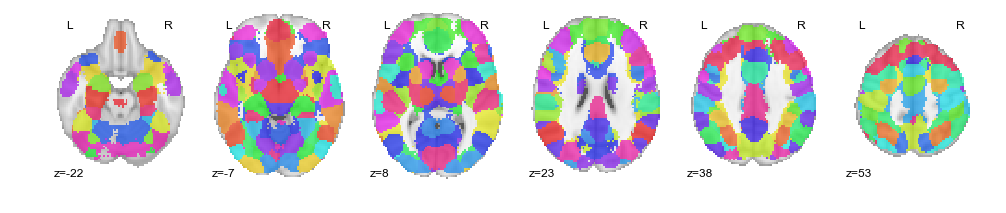

In [290]:
niplt.plot_roi(nib.Nifti1Image(masker.unmask(kmeans_labels[4][1] + 1), masker.get_header().get_best_affine()), draw_cross=False,
              cmap=mplcolors.ListedColormap(colors), display_mode='z', cut_coords=np.arange(-22, 55, 15), annotate=True)

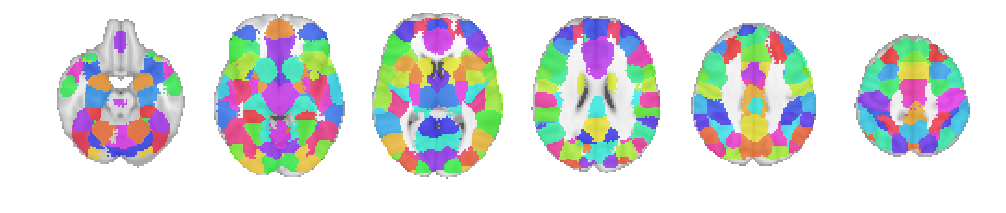

In [286]:
niplt.plot_roi(nib.Nifti1Image(masker.unmask(kmeans_scaled_labels[4][1] + 1), masker.get_header().get_best_affine()), draw_cross=False,
              cmap=mplcolors.ListedColormap(colors), display_mode='z', cut_coords=np.arange(-22, 55, 15), annotate=False)

### Silhouette

In [735]:
sils = joblib.load('../results/clustering/bootstrap/ward_silhouette.pkl') + joblib.load('../results/clustering/bootstrap/kmeans_silhouette.pkl')
sils = pd.DataFrame(sils, columns=['algorithm', 'type', 'n_reg', 'sil'])

In [737]:
sils['Algorithm'] = sils.algorithm.map({'ward' : 'Ward', 'kmeans' : 'K-means'})
sils['Preprocessing'] = sils.type.map({'original' : 'Original', 'scaled' : 'Standardized'})
sils['Clustering'] = sils['Algorithm'] + " " + sils['Preprocessing']

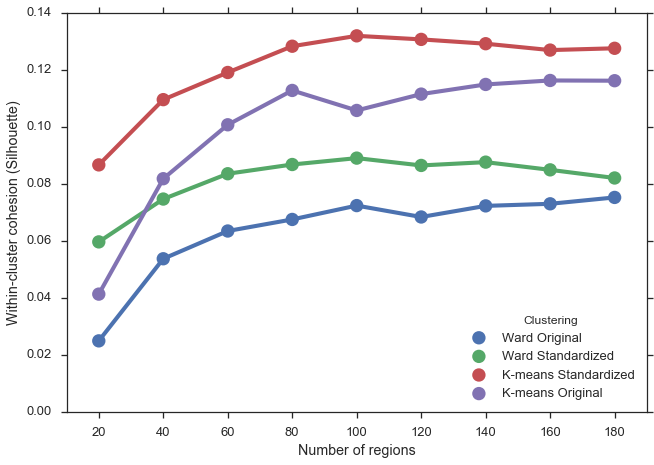

In [744]:
g = sns.pointplot('n_reg', 'sil', hue='Clustering', data=sils, fit_reg=False, col='algorithm', scatter_kws={'s' : 60}, ci=0)
g.axes.set_xlabel('Number of regions')
g.axes.set_ylabel('Within-cluster cohesion (Silhouette)')